<a href="https://colab.research.google.com/github/OluwatodimuAdegoke/ComputerVisionCourse/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import tensorflow as tf # Models
import pandas as pd  # Reading and processing data
import seaborn as sns # Visualization
import numpy as np
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import RootMeanSquaredError

Data Preparation

In [2]:
# Read the data
data = pd.read_csv("train.csv",sep=',')
data.shape
# Plots the graphs of each variable against the other
# sns.pairplot(data[['years','km','rating','condition','economy','top speed','hp', 'torque','current price']])

(1000, 12)

In [3]:
tensor_data = tf.constant(data)
# Cast to float32
tensor_data = tf.cast(tensor_data,tf.float32)
# Shuffle the data to avoid bias
tensor_data = tf.random.shuffle(tensor_data)


In [4]:
x = tensor_data[:,3:-1]
print(x.shape)
y = tensor_data[:,-1]
y = tf.expand_dims(y, axis = -1)
print(y.shape)

(1000, 8)
(1000, 1)


In [61]:
#Divide the dataset into training, validation and testing data
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(x)


In [62]:
x_train = x[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(x_train.shape)

(800, 8)


In [71]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
x_val = x[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(x_val.shape)

x_test = x[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(x_test.shape)

(100, 8)
(100, 8)


In [74]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)


In [97]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)


In [98]:
# Normalize the input
normalizer = Normalization()
# Gets the mean and std itself
normalizer.adapt(x_train)
normalizer(x_train)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[-0.3451495 , -1.1255285 , -1.4195638 , -1.614912  ,  1.0933096 ,
        -0.10946778,  1.6782013 ,  0.81605536],
       [-0.9326389 , -0.52780145,  1.4231169 , -1.614912  ,  0.64315695,
        -1.0466572 ,  0.4715137 ,  0.48526224],
       [-1.5201283 ,  0.47419474,  1.4231169 , -1.2592045 , -0.70730114,
         0.46325907,  0.5680487 , -1.6412652 ],
       [ 1.4173186 ,  0.8737747 , -1.4195638 , -1.614912  , -1.6076065 ,
        -1.0466572 ,  0.6163162 ,  0.7215431 ],
       [-1.5201283 ,  0.34149203, -1.4195638 , -0.90349704, -1.1574538 ,
         0.6194573 , -1.3626515 ,  0.76879925]], dtype=float32)>

In [99]:
# Create a model with keras
model = tf.keras.Sequential([
    InputLayer(input_shape=(8,)),
    normalizer,
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(1)])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 8)                 17        
 tion)                                                           
                                                                 
 dense_15 (Dense)            (None, 128)               1152      
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 34322 (134.07 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 17 (72.00 Byte)
______________

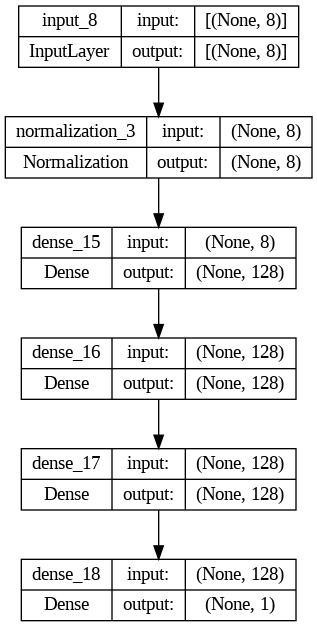

In [100]:
tf.keras.utils.plot_model(model,to_file="model.png",show_shapes=True)

In [102]:
# Uses the mean square error. Can also use the mean absolute error
# Use mean absolute error when there is a outlier that'll affect the data
# Can also use Huber loss
model.compile(optimizer=Adam(learning_rate = 0.1),
              loss=MeanAbsoluteError(),
              metrics = RootMeanSquaredError())

In [103]:
# Training the model
#
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    verbose=1)

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 148284.9375 - root_mean_squared_error: 194877.7656 - val_loss: 49530.8789 - val_root_mean_squared_error: 60498.1055
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 56598.0312 - root_mean_squared_error: 70495.8516 - val_loss: 48286.8555 - val_root_mean_squared_error: 59431.7031
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 49860.3555 - root_mean_squared_error: 63331.1016 - val_loss: 46432.6445 - val_root_mean_squared_error: 57340.1953
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 44823.8398 - root_mean_squared_error: 56867.6250 - val_loss: 41772.7266 - val_root_mean_squared_error: 51725.3086
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 40630.2148 - root_mean_squared_error: 50998.8555 - val_loss: 40736.9141 - val_root_mean_squared_error: 50275.1016
Epoch 6/100
25/25 [==============================] - 0s 2ms/st

<function matplotlib.pyplot.show(close=None, block=None)>

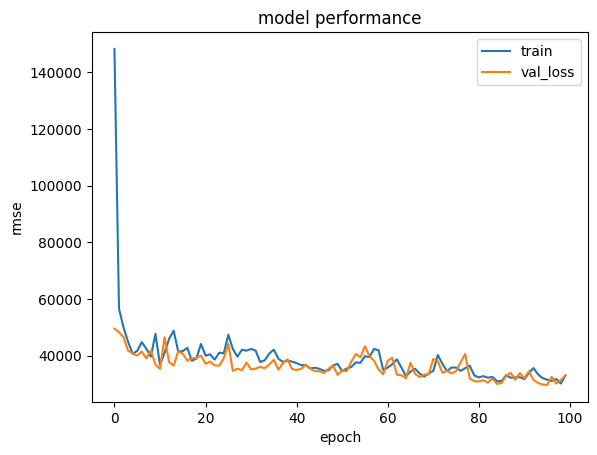

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train','val_loss'])
plt.show

In [105]:
# Evaluate the model
model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 4ms/step - loss: 38525.0664 - root_mean_squared_error: 49168.4219


[38525.06640625, 49168.421875]

In [106]:
model.predict(tf.expand_dims(x_test[0],axis = 0))


1/1 [==============================] - 0s 75ms/step


array([[317815.28]], dtype=float32)

In [107]:
y_true = list(y_test[:,0].numpy())
y_pred = list(model.predict(x_test)[:,0])


4/4 [==============================] - 0s 2ms/step


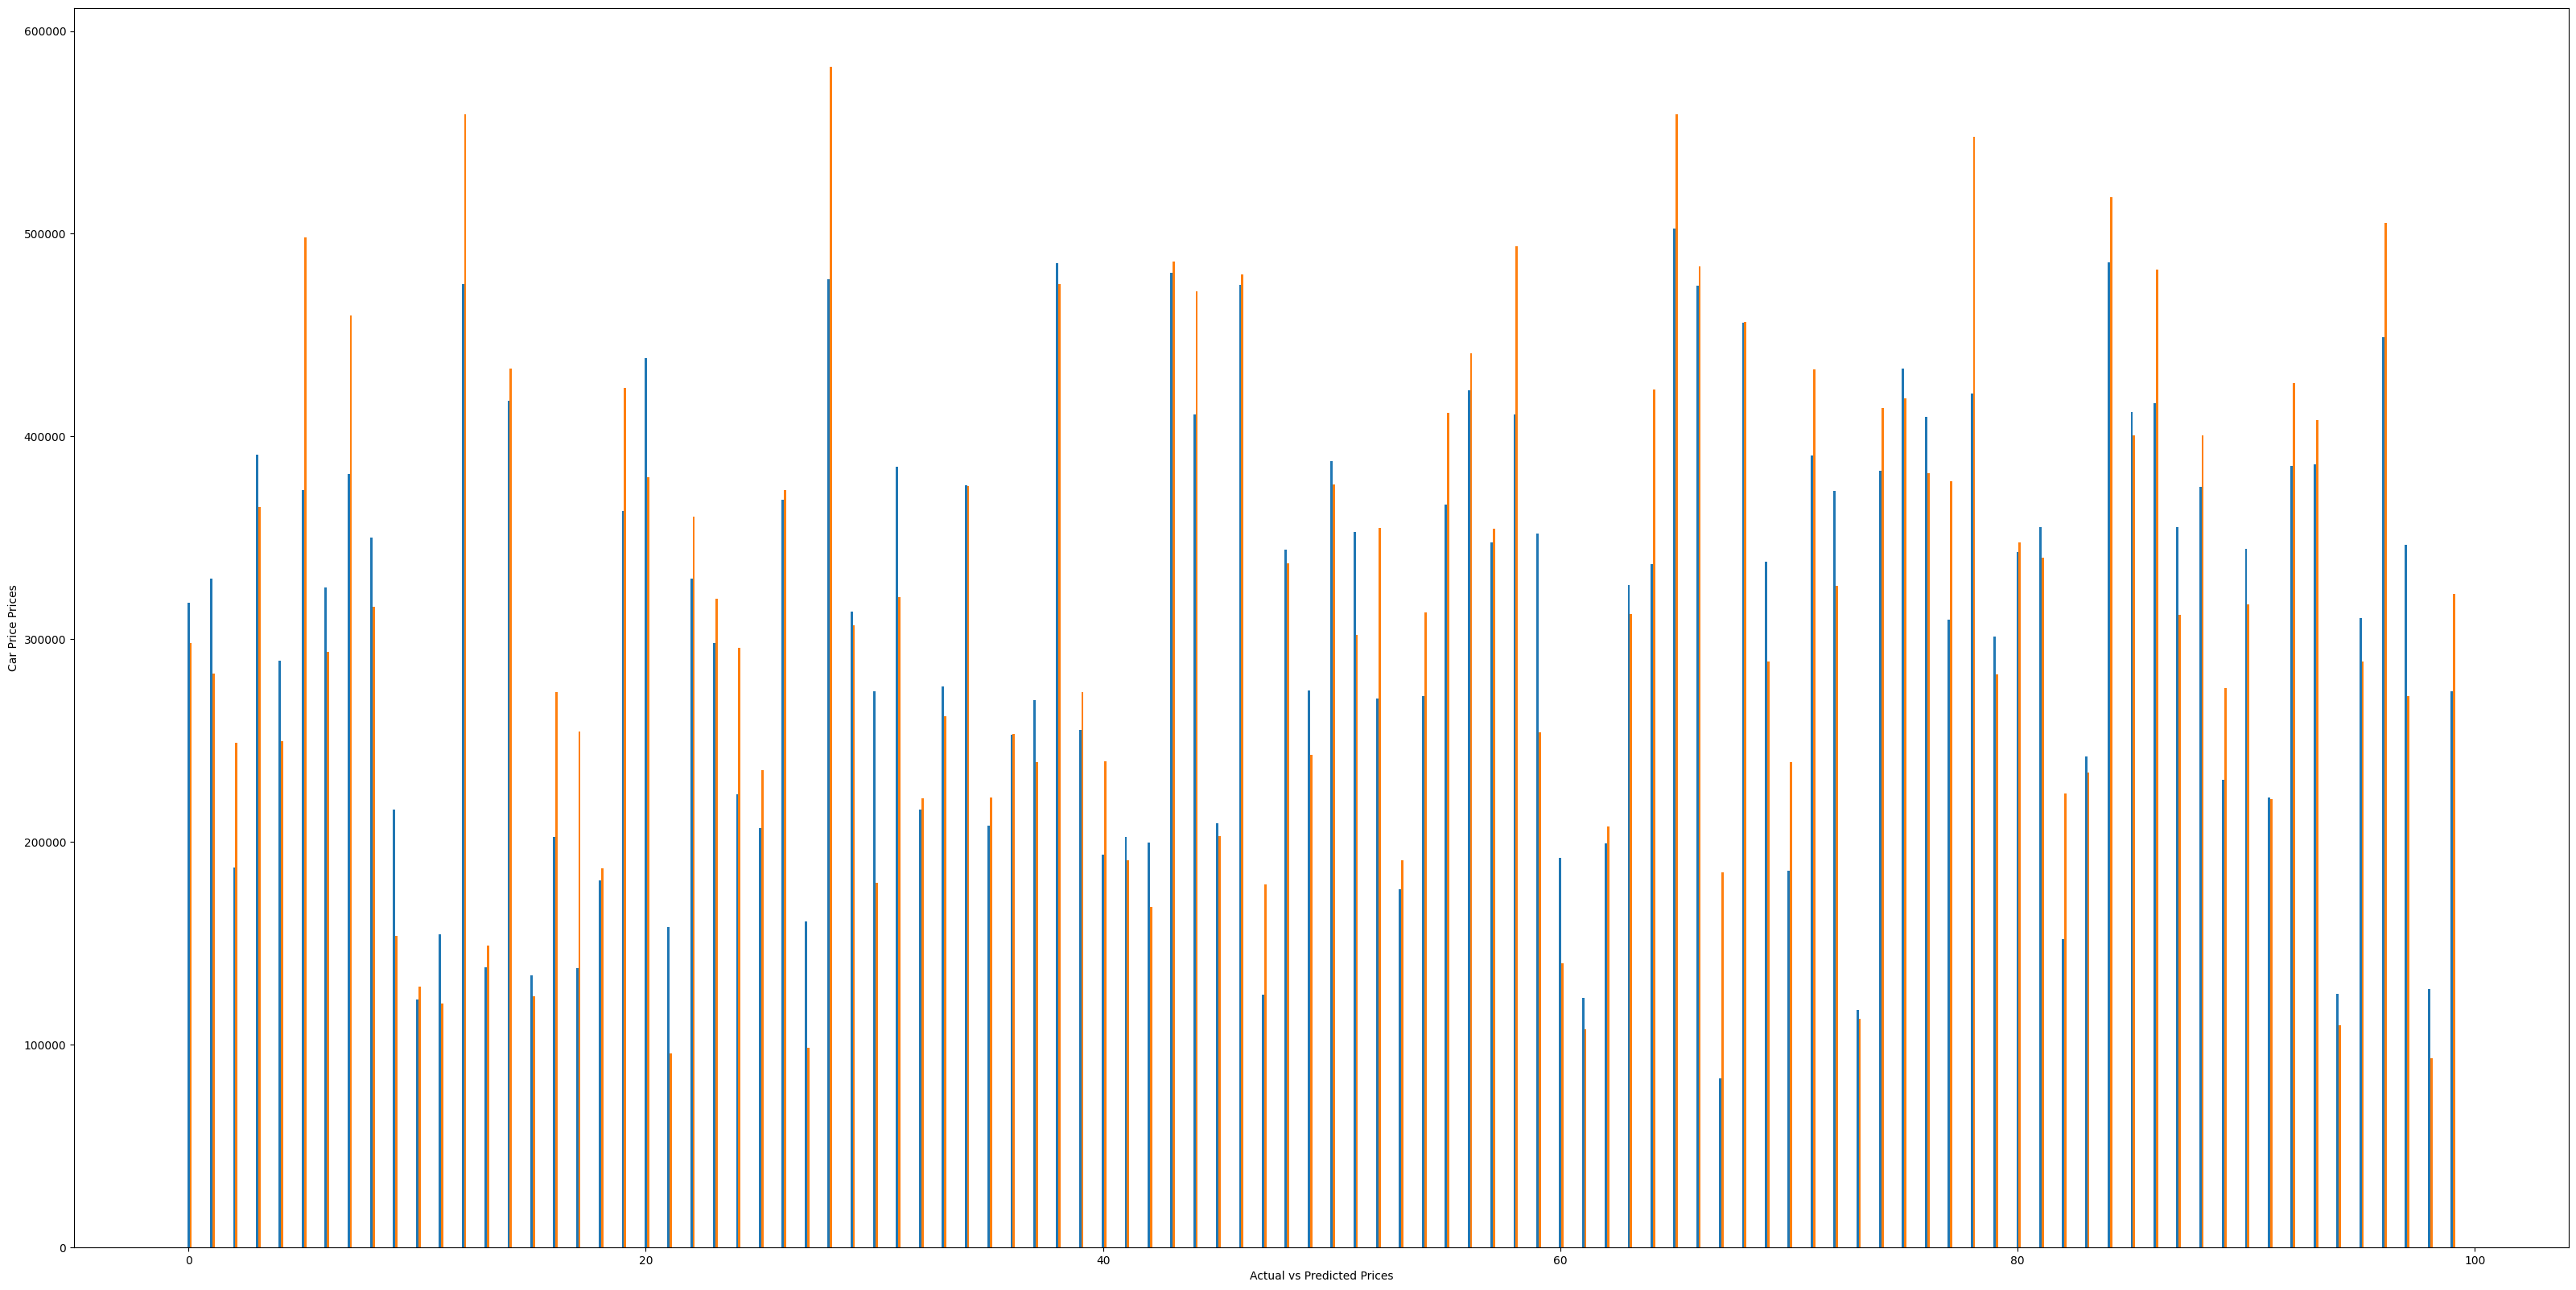

In [108]:
ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.1

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label='Actual Car Price')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')

plt.show()